# Google Trends: Feature Exploration

### All Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from plot.ts import get_lead_matrix, plot_ccf
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from glob import glob
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import ccf
from word_list.basic import politics1, politics2
from word_list.basic import business, control

## Variables

In [3]:
TRAIN_DATE_FIRST = "2004-01-04" 
TRAIN_DATE_LAST = "2012-12-16" 
INSTRUMENT = "es1"
INSTRUMENT_PRICE_COLUMN = 'PX_LAST'
INSTRUMENT_DATE_COLUMN = 'date'

## Loading market data and defining return variable

For a day $t$, and an instrument with price $P_t$, we define the target variable $R_t$ as the *simple return*:

\begin{equation}
R_t = \frac{(P_t - P_{t-1})}{P_{t-1}}
\end{equation}

### es1 target data (2004 - 2012)

,es1_returns
date,
2004-01-05,0.009919
2004-01-06,0.001782
2004-01-07,0.003123
2004-01-08,0.003556
2004-01-09,-0.008413


#### shape = (2273, 1)

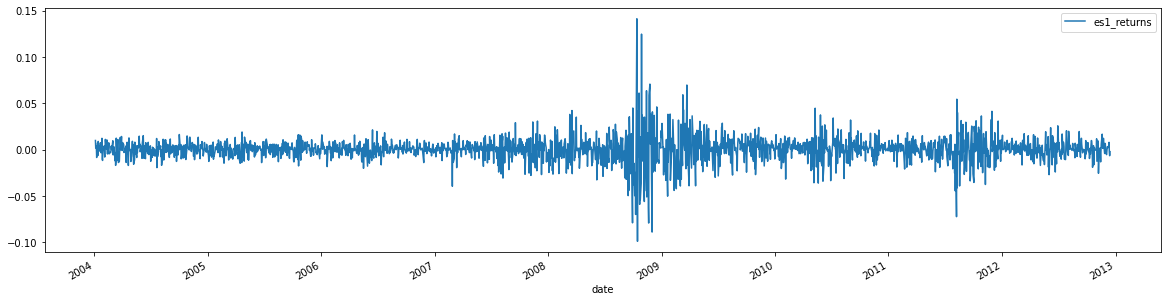

In [4]:
market_path = os.path.join('data','market',"{}.txt".format(INSTRUMENT))
df_market = pd.read_csv(market_path, sep='\t')
df_market.loc[:, INSTRUMENT_DATE_COLUMN] = pd.to_datetime(df_market[INSTRUMENT_DATE_COLUMN])
df_market = df_market.set_index(INSTRUMENT_DATE_COLUMN)
close = df_market[[INSTRUMENT_PRICE_COLUMN]].dropna()
target = close.pct_change().dropna()
target_name = "{}_returns".format(INSTRUMENT) 
target.columns = [target_name]
target = target[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]

display(Markdown("### {} target data ({} - {})".format(INSTRUMENT,
                                                       TRAIN_DATE_FIRST.split("-")[0],
                                                       TRAIN_DATE_LAST.split("-")[0])))
display(HTML(target.head(5).to_html()))
display(Markdown("#### shape = {}".format(target.shape)))
display(Markdown(" "))
fig, ax = plt.subplots(figsize=(20,5))
target.plot(ax=ax);

## Google trends data

Let ${S^{w}}_t$ be the search interest in the word $w$ at day $t$.

### Google trends data (2004 - 2012)

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-04,1.0,1.0,18.0,26.0,57.0,5.0,0.0,6.0,6.0,51.0,81.0,17.0,84.0,51.0,26.0,10.0,1.0,3.0,68.0,27.0,3.0,50.0,18.0,4.0,1.0,3.0,0.0,13.0,10.0,67.0,27.0,10.0,53.0,3.0,7.0,5.0,7.0,8.0,2.0,19.0,31.0,2.0,1.0,1.0,0.0,5.0,3.0,4.0,1.0,4.0,1.0,18.0,4.0,3.0,29.0,5.0,17.0,13.0,4.0,0.0,61.0,1.0,1.0,8.0,18.0,4.0,2.0,23.0,46.0,12.0,30.0,21.0,2.0,1.0,8.0,12.0,1.0,55.0,1.0,21.0,100.0,86.0,11.0,43.0,28.0,9.0,1.0,1.0,8.0,3.0,8.0,14.0,26.0,13.0,46.0,11.0,1.0,2.0,14.0,5.0,26.0,25.0,9.0,3.0,19.0,26.0,43.0,6.0,3.0,5.0,3.0,3.0,20.0,29.0,3.0,83.0,2.0,1.0,62.0,60.0,24.0,3.0,1.0,41.0,26.0,32.0,10.0,2.0,2.0,3.0,10.0,27.0,2.0,31.0,5.0,7.0,2.0,5.0,38.0,24.0,1.0,7.0,7.0,14.0,35.0,6.0,6.0,4.0,30.0,11.0,6.0,2.0,1.0,79.0,38.0,22.0,21.0,32.0,8.0,26.0,6.0,3.0,24.0,21.0,70.0,8.0,9.0,26.0,0.0,57.0,10.0,37.0,16.0,1.0,56.0,1.0,1.0,1.0,60.0,68.0,48.0,34.0,1.0,29.0,87.0,85.0
2004-01-05,0.0,1.0,21.0,29.0,50.0,2.0,0.0,5.0,3.0,52.0,71.0,23.0,82.0,47.0,26.0,10.0,4.0,2.0,100.0,34.0,4.0,88.0,19.0,2.0,0.0,5.0,0.0,10.0,11.0,71.0,28.0,14.0,55.0,2.0,9.0,6.0,5.0,9.0,0.0,19.0,58.0,2.0,2.0,3.0,1.0,6.0,5.0,3.0,2.0,5.0,2.0,11.0,6.0,2.0,25.0,5.0,18.0,6.0,8.0,0.0,57.0,0.0,3.0,8.0,23.0,5.0,1.0,20.0,38.0,10.0,33.0,25.0,5.0,1.0,6.0,8.0,1.0,54.0,2.0,21.0,87.0,79.0,11.0,36.0,30.0,7.0,4.0,1.0,10.0,5.0,5.0,14.0,22.0,11.0,52.0,16.0,0.0,2.0,15.0,4.0,36.0,22.0,13.0,3.0,34.0,24.0,43.0,5.0,1.0,4.0,3.0,6.0,20.0,29.0,6.0,73.0,3.0,2.0,54.0,49.0,23.0,4.0,2.0,30.0,21.0,30.0,7.0,5.0,3.0,2.0,13.0,29.0,2.0,28.0,5.0,7.0,2.0,6.0,30.0,22.0,2.0,5.0,8.0,12.0,37.0,2.0,4.0,3.0,35.0,7.0,2.0,2.0,2.0,70.0,44.0,20.0,17.0,33.0,6.0,29.0,6.0,3.0,21.0,19.0,66.0,12.0,13.0,18.0,2.0,60.0,4.0,31.0,12.0,0.0,57.0,2.0,2.0,2.0,64.0,67.0,51.0,39.0,0.0,30.0,91.0,70.0
2004-01-06,0.0,2.0,31.0,30.0,87.0,7.0,0.0,4.0,4.0,86.0,66.0,27.0,78.0,57.0,26.0,11.0,3.0,2.0,89.0,32.0,9.0,87.0,32.0,3.0,1.0,1.0,1.0,37.0,19.0,96.0,48.0,10.0,74.0,3.0,13.0,5.0,7.0,7.0,1.0,33.0,62.0,2.0,2.0,1.0,1.0,10.0,7.0,6.0,1.0,7.0,2.0,24.0,8.0,6.0,54.0,16.0,36.0,8.0,7.0,2.0,62.0,1.0,2.0,7.0,17.0,4.0,1.0,21.0,62.0,19.0,23.0,36.0,6.0,1.0,11.0,10.0,1.0,94.0,2.0,28.0,87.0,85.0,12.0,50.0,56.0,14.0,2.0,2.0,10.0,4.0,9.0,16.0,16.0,16.0,66.0,22.0,0.0,3.0,13.0,10.0,59.0,32.0,21.0,5.0,17.0,34.0,42.0,6.0,3.0,5.0,1.0,6.0,25.0,27.0,4.0,45.0,3.0,2.0,100.0,82.0,27.0,2.0,1.0,36.0,34.0,35.0,12.0,4.0,5.0,2.0,18.0,37.0,5.0,38.0,3.0,5.0,4.0,7.0,47.0,15.0,2.0,11.0,8.0,17.0,24.0,10.0

#### shape = (3270, 186)

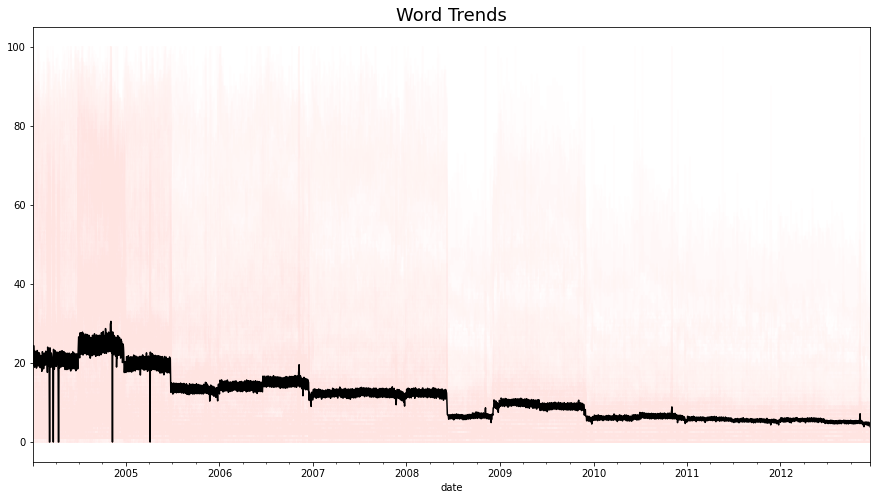

In [5]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_list = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_list.append(ts)

trends = pd.concat(trends_list,1)
trends = trends.fillna(0.0)
words = list(trends.columns)
words.sort()
words.remove("notability") # only zero info in this dataset
politics2 = [w for w in politics2 if w != "notability"] # only zero info in this dataset

trends = trends[words]
trends = trends[TRAIN_DATE_FIRST: TRAIN_DATE_LAST]


display(Markdown("### Google trends data ({} - {})".format(TRAIN_DATE_FIRST.split("-")[0],
                                                           TRAIN_DATE_LAST.split("-")[0])))
display(HTML(trends.head(5).to_html()))
display(Markdown("#### shape = {}".format(trends.shape))) 

fig, ax = plt.subplots(figsize=(15,8))
trends.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends.mean(1).plot(ax=ax,legend=False, color="k", label="mean trend");
ax.set_title("Word Trends", fontsize=18);

## Creating Features

For $k \in \{1, \dots, K\}$ and word $w$, we define the word feature ${D^{w}}_t$ as the $k$ difference:

\begin{equation}
{D^{w}}_{k,t} = {S^{w}}_t - {S^{w}}_{t-k}
\end{equation}


In [6]:
K = 30
features_list = []

for k in range(1, K+1):
    feat = trends.diff(k).add_suffix('_diff_{}'.format(k))
    features_list.append(feat)
    
trend_features = pd.concat(features_list, 1)

display(Markdown("### Word Features"))
display(HTML(trend_features.head(5).to_html()))
display(Markdown("#### shape = {}".format(trend_features.shape)))

### Word Features

#### shape = (3270, 5580)

## Selection Method 1

For each feature ${D^{w}}_{k,t}$ we:

- 1) merge ${D^{w}}_{k,t}$ and $R_{t}$ in order to align the indexes;
- 2) lag ${D^{w}}_{k,t}$ by **one day**.
- 3) calculate the absolute value of the correlation between the lagged version of ${D^{w}}_{k,t}$ and $R_t$:

\begin{equation}
corr\text{-}score_1(w,k) = |\hat{\rho}_{D^w_k, R}(-1) |
\end{equation}

where $\hat{\rho}$ is the sample cross-correlation function.

With this method we can rank all google trend features and select the top 5 features. It is also possible to associate a score to each word $w$: 

\begin{equation}
score_1(w) = \frac{1}{K}\sum_{k=1}^{K} corr\text{-}score_1(w,k)
\end{equation}


### Method 1 Functions

In [7]:
def get_merged_ts(feature_df,
                  feature_name,
                  target_ts,
                  target_name,
                  tolerance=pd.Timedelta("1d")):

    merged_df = pd.merge_asof(feature_df[feature_name].to_frame(),
                              target_ts,
                              left_index=True,
                              right_index=True,
                              tolerance=tolerance)
    merged_df = merged_df.dropna()
    merged_feature, merged_target = merged_df[feature_name],merged_df[target_name] 
    return merged_feature, merged_target


def corr_score_1(feature_ts, target_ts):
    return np.abs(ccf(target_ts, feature_ts)[1])

### Applying Method 1

In [8]:
method_1_results = []

for w in tqdm(words, desc='word'):
    for k in range(1, K+1):
        feature_name = "{}_diff_{}".format(w,k)
        f, t = get_merged_ts(feature_df=trend_features,
                             feature_name=feature_name,
                             target_ts=target,
                             target_name=target_name)
        
        score = corr_score_1(f,t)
        obs = (w,k,score)
        method_1_results.append(obs)

method_1_results = pd.DataFrame(method_1_results, columns=["word","k","score"])
method_1_results = method_1_results.sort_values("score",ascending=False)
method_1_results = method_1_results.reset_index(drop=True)

word: 100%|██████████| 186/186 [00:29<00:00,  6.41it/s]


### Method 1 Results

In [9]:
display(Markdown("#### 1) Top 5 Features"))
display(HTML(method_1_results.head(5).to_html()))

display(Markdown(""))

display(Markdown("#### 2) Bottom 5 Features"))
display(HTML(method_1_results.tail(5).to_html()))

display(Markdown(""))

word_rank1 = method_1_results.groupby("word").mean().score.sort_values(ascending=False).to_frame()

display(Markdown("#### 3) Top 5 words"))
display(HTML(word_rank1.head(5).to_html()))

display(Markdown("#### 4) Bottom 5 words"))
display(HTML(word_rank1.tail(5).to_html()))

#### 1) Top 5 Features

,word,k,score
0,dow_jones,19,0.068673
1,election,21,0.061354
2,DOW_JONES,19,0.060716
3,debt,20,0.059229
4,DOW_JONES,7,0.059183


#### 2) Bottom 5 Features

,word,k,score
5575,tourism,26,8.555287e-06
5576,economic,27,6.021531e-06
5577,products,6,1.870256e-06
5578,headlines,10,1.219433e-06
5579,council,19,7.812569e-07


#### 3) Top 5 words

,score
word,
holiday,0.027820
cash,0.025649
food,0.025138
markets,0.024905
election,0.023893


#### 4) Bottom 5 words

,score
word,
economy,0.005797
conty,0.005735
voters,0.005554
default,0.005516
political,0.005301


#### 5) Category distribution

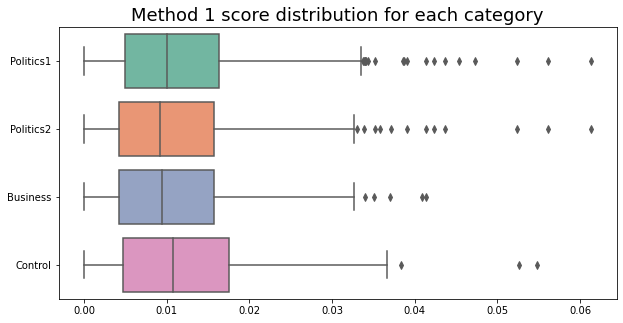

In [11]:
method_1_politics1 =  method_1_results.set_index("word").loc[politics1].score.values
method_1_politics2 =  method_1_results.set_index("word").loc[politics2].score.values

# hack. We have a problem with the word "notability"
method_1_politics2 = np.concatenate([method_1_politics2, [float("nan")]*30]) 

method_1_business =  method_1_results.set_index("word").loc[business].score.values
method_1_control =  method_1_results.set_index("word").loc[control].score.values


method_1_cat = np.stack([method_1_politics1,
                         method_1_politics2,
                         method_1_business,
                         method_1_control],1)
method_1_cat = pd.DataFrame(method_1_cat,columns=["Politics1",
                                                  "Politics2",
                                                  "Business",
                                                  "Control"])
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=method_1_cat, orient="h", palette="Set2",ax=ax)
ax.set_title("Method 1 score distribution for each category", fontsize=18);

## Selection Method 2

For each feature ${D^{w}}_{k,t}$ we:

- 1) merge ${D^{w}}_{k,t}$ and $R_{t}$ in order to align the indexes;
- 2) calculate the **mean absolute value of the correlations** between ${D^{w}}_{k,t-l}$ (where $l \in \{1, \dots, L\}$) and $R_t$:

\begin{equation}
corr\text{-}score_2(w,k) = \frac{1}{L}\sum_{l=1}^{L} |\hat{\rho}_{D^w_k, R}(-l) |
\end{equation}

Similar to method 1, we have for each word $w$: 

\begin{equation}
score_2(w) = \frac{1}{K}\sum_{k=1}^{K} corr\text{-}score_2(w,k)
\end{equation}

### Method 2 Functions

In [12]:
L = 10
def corr_score_2(feature_ts, target_ts, max_lag=L):
    scores = np.abs(ccf(target_ts, feature_ts)[:max_lag+1]) 
    return scores

### Applying Method 2

In [13]:
method_2_results = []
method_2_raw_results = []

for w in tqdm(words, desc='word'):    
    for k in range(1, K+1):
        feature_name = "{}_diff_{}".format(w,k)
        f, t = get_merged_ts(feature_df=trend_features,
                             feature_name=feature_name,
                             target_ts=target,
                             target_name=target_name)
        
        score = corr_score_2(f,t)
        for l in range(1, L+1):
            obs = (w,k,l, score[l])
            method_2_raw_results.append(obs)
        method_2_results.append((w,k,np.mean(score[1:])))

method_2_results = pd.DataFrame(method_2_results, columns=["word","k","score"])
method_2_results = method_2_results.sort_values("score",ascending=False)
method_2_results = method_2_results.reset_index(drop=True)

method_2_raw_results = pd.DataFrame(method_2_raw_results, columns=["word","lag","k","score"])
method_2_raw_results = method_2_raw_results.sort_values("score",ascending=False)
method_2_raw_results = method_2_raw_results.reset_index(drop=True)

word: 100%|██████████| 186/186 [00:28<00:00,  6.55it/s]


In [14]:
display(Markdown("#### 1) Top 5 Features"))
display(HTML(method_2_raw_results.head(5).to_html()))

display(Markdown(""))

display(Markdown("#### 2) Bottom 5 Features"))
display(HTML(method_2_raw_results.tail(5).to_html()))

display(Markdown(""))

word_rank2 = method_2_results.groupby("word").mean().score.sort_values(ascending=False).to_frame()

display(Markdown("#### 3) Top 5 words"))
display(HTML(word_rank2.head(5).to_html()))

display(Markdown("#### 4) Bottom 5 words"))
display(HTML(word_rank2.tail(5).to_html()))

#### 1) Top 5 Features

,word,lag,k,score
0,dow_jones,12,7,0.106202
1,DOW_JONES,12,7,0.103888
2,dow_jones,11,8,0.102046
3,DOW_JONES,21,7,0.101689
4,dow_jones,21,7,0.099045


#### 2) Bottom 5 Features

,word,lag,k,score
55795,headlines,10,1,1.219433e-06
55796,council,19,1,7.812569e-07
55797,dividend,16,8,2.913945e-07
55798,service,15,3,1.935627e-07
55799,markets,20,3,3.202236e-08


#### 3) Top 5 words

,score
word,
dow_jones,0.030893
DOW_JONES,0.029828
debt,0.023290
election,0.022201
buy,0.020274


#### 4) Bottom 5 words

,score
word,
judge,0.007217
republican,0.007216
greed,0.007205
voters,0.006573
political,0.006201


#### 5) Category distribution

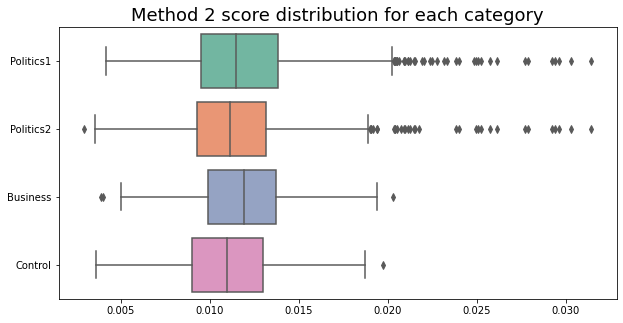

In [15]:
method_2_politics1 =  method_2_results.set_index("word").loc[politics1].score.values
method_2_politics2 =  method_2_results.set_index("word").loc[politics2].score.values

# hack. We have a problem with the word "notability"
method_2_politics2 = np.concatenate([method_2_politics2, [float("nan")]*30]) 

method_2_business =  method_2_results.set_index("word").loc[business].score.values

method_2_control =  method_2_results.set_index("word").loc[control].score.values



method_2_cat = np.stack([method_2_politics1,
                         method_2_politics2,
                         method_2_business,
                         method_2_control],1)
method_2_cat = pd.DataFrame(method_2_cat,
                            columns=["Politics1",
                                     "Politics2",
                                     "Business",
                                     "Control"])
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=method_2_cat, orient="h", palette="Set2",ax=ax)
ax.set_title("Method 2 score distribution for each category", fontsize=18);